## ANLP Assignment 1: Sentiment Analysis
### Christopher Hamilton,  a1766121

In [1]:
import json
import os

import pandas as pd
import numpy as np

### 1. Reading dataset and initial pre-processing

In [2]:
def read_json_to_df(file_name):
    data = []
    with open(file_name) as data_file:
        for line in data_file:
            # Load each line of the JSON file as a dictionary
            data.append(json.loads(line))

    # Form a Pandas DataFrame from the dictionaries
    return pd.json_normalize(data)

# Load the training and test data
raw_train_df = read_json_to_df("hotel_reviews_train.json")
raw_test_df = read_json_to_df("hotel_reviews_test.json")

In [3]:
raw_train_df.head()

,title,text,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,ratings.service,ratings.cleanliness,...,ratings.rooms,author.username,author.num_reviews,author.id,author.location,author.num_cities,author.num_helpful_votes,author.num_type_reviews,ratings.check_in_front_desk,ratings.business_service_(e_g_internet_access)
0,“Horrible experience”,First of all we got there and they didn't have...,September 2012,80138,0,"September 19, 2012",140716137,False,1.0,2.0,...,1.0,Kh3RD,1.0,AB404BB664D653ECF79DE0E0867F6D34,"Las Vegas, Nevada",NaN,NaN,NaN,NaN,NaN
1,“Stay Away”,Found Racist graffiti in the room. Request to ...,June 2011,240151,1,"June 27, 2011",114807323,False,1.0,1.0,...,NaN,TheUglyPhotographer,4.0,BB116F87FE8F9AB356F63853BFD32FFE,"Oceanside, California",3.0,4.0,4.0,NaN,NaN
2,“Great location and service”,Close to Union Square - hotel is a bit of a ma...,October 2010,80793,0,"October 25, 2010",84805430,False,4.0,5.0,...,4.0,Moonstonemoclips,48.0,F3D0CF371B788300E73A1413B2DABB4B,Kirkland,31.0,27.0,32.0,NaN,NaN
3,“I will never go back here again!”,I had a bad vibe about this place from the mom...,June 2012,111418,1,"June 28, 2012",132971117,False,3.0,2.0,...,1.0,JoanellenJ,22.0,BC6BC07F81B768F78B6CE17A18762C11,New York,10.0,9.0,5.0,NaN,NaN
4,“Ripped off our VISA card after departure”,"After we received our ""final"" bill and left th...",January 2012,671150,3,"February 4, 2012",124104157,False,NaN,NaN,...,NaN,Lynnworks,3.0,F7E9D044FA2554FD06A871289312E043,Providence,3.0,7.0,3.0,NaN,NaN


In [4]:
raw_test_df.head()

,title,text,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,ratings.service,ratings.cleanliness,...,ratings.rooms,author.username,author.num_cities,author.num_helpful_votes,author.num_reviews,author.num_type_reviews,author.id,author.location,ratings.check_in_front_desk,ratings.business_service_(e_g_internet_access)
0,“I was SO surprised! I WILL return!”,My husband and I just celebrated our 25th wedd...,November 2011,1783324,1,"November 26, 2011",121063682,False,5.0,5.0,...,5.0,shooflyfarm,15.0,12.0,30.0,11.0,02C39D355EE31BFA82F2724523782A92,"Opelika, Alabama",NaN,NaN
1,“A Mother/Daughter vacation”,I could not leave a bad comment on any part of...,August 2011,88458,0,"August 10, 2011",116545869,False,5.0,5.0,...,NaN,bestmpm,NaN,NaN,1.0,NaN,8F37B44FE89FD626313A7CB4B381FE40,Chattanooga,NaN,NaN
2,“Good Choice for Pre-cruise”,I spent one night at this hotel prior to a cru...,November 2010,82868,0,"December 6, 2010",89196759,False,5.0,5.0,...,5.0,Conner2dood,20.0,39.0,26.0,24.0,5E57B2B21C69F07E617D67C748DF010A,Pennsylvania,NaN,NaN
3,“Unsung Hero”,"For the past year and a half, my daughter has ...",July 2011,98979,0,"July 28, 2011",115879719,False,5.0,5.0,...,NaN,LeviK,2.0,NaN,2.0,NaN,D7E5C22B3A877DEA1434B18E797FEE19,,NaN,NaN
4,"“Great Value for a King, Queen, and Princesses.”","Great Value for a King, Queen, and Princesses....",March 2007,112273,8,"March 21, 2007",7198417,False,5.0,5.0,...,5.0,thomrho,13.0,25.0,27.0,4.0,EEE6C615C8EBCA4AFD2774810E590274,"albuquerque, nm",5.0,5.0


In [64]:
# Select the title, text and overall rating columns
train_df = raw_train_df[["title", "text", "ratings.overall"]]
test_df = raw_test_df[["title", "text", "ratings.overall"]]

# Check the value counts for the ratings
print("Training data ratings")
print(train_df["ratings.overall"].value_counts())

print()

print("Test data ratings")
print(test_df["ratings.overall"].value_counts())

Training data ratings
ratings.overall
5.0    9825
4.0    7720
3.0    3287
2.0    1611
1.0    1557
Name: count, dtype: int64

Test data ratings
ratings.overall
5.0    2468
4.0    1933
3.0     793
2.0     420
1.0     385
0.0       1
Name: count, dtype: int64


In [ ]:
# Find indices of rows where the rating is 0
zero_rating_indices = test_df[test_df['ratings.overall'] == 0].index
for index in zero_rating_indices:
    # Print the text corresponding to the zero rating
    print(test_df['text'][index])

Best location. Right where Pier 39 is. Lots of things to do around the area, restaurants and sight seeing. Staff are friendly. Great service. Will come back again :)


In [71]:
# Based on the above text, it is unlikely the reviewer meant to give a low rating
# Instead, we will remvoe the 0 from the dataset
test_df = test_df.drop(zero_rating_indices)

In [72]:
# Check the value counts for the ratings
print("Test data ratings")
print(test_df["ratings.overall"].value_counts())

Test data ratings
ratings.overall
5.0    2468
4.0    1933
3.0     793
2.0     420
1.0     385
Name: count, dtype: int64


In [73]:
# Remove remove non-alphanumeric characters from the title and text columns
# https://saturncloud.io/blog/how-to-remove-special-characters-in-pandas-dataframe/#use-lambda-function

train_df.loc[:, 'title'] = train_df['title'].apply(lambda x: ''.join(char for char in x if char.isalnum() or char.isspace()))
train_df.loc[:, 'text'] = train_df['text'].apply(lambda x: ''.join(char for char in x if char.isalnum() or char.isspace()))

test_df.loc[:, 'title'] = test_df['title'].apply(lambda x: ''.join(char for char in x if char.isalnum() or char.isspace()))
test_df.loc[:, 'text'] = test_df['text'].apply(lambda x: ''.join(char for char in x if char.isalnum() or char.isspace()))

In [74]:
train_df.head()

,title,text,ratings.overall
0,Horrible experience,First of all we got there and they didnt have ...,1.0
1,Stay Away,Found Racist graffiti in the room Request to c...,1.0
2,Great location and service,Close to Union Square hotel is a bit of a maz...,4.0
3,I will never go back here again,I had a bad vibe about this place from the mom...,2.0
4,Ripped off our VISA card after departure,After we received our final bill and left the ...,1.0


In [75]:
test_df.head()

,title,text,ratings.overall
0,I was SO surprised I WILL return,My husband and I just celebrated our 25th wedd...,5.0
1,A MotherDaughter vacation,I could not leave a bad comment on any part of...,5.0
2,Good Choice for Precruise,I spent one night at this hotel prior to a cru...,4.0
3,Unsung Hero,For the past year and a half my daughter has b...,5.0
4,Great Value for a King Queen and Princesses,Great Value for a King Queen and Princesses We...,5.0


In [76]:
from langdetect import detect as detect_language

def filter_english_reviews(df):
    def is_english(text):
        try:
            return detect_language(text) == "en"
        except:
            return False

    # Filter the DataFrame for reviews where both title and text are in English
    return df[df['text'].apply(is_english) & df['title'].apply(is_english)]

In [77]:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html
# https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html

# Save the English reviews to a CSV file to save time filtering when running again
if os.path.exists("english_hotel_reviews_train.csv"):
    train_df = pd.read_csv("english_hotel_reviews_train.csv")
else:
    train_df = filter_english_reviews(train_df)
    train_df.to_csv("english_hotel_reviews_train.csv", index=False)

if os.path.exists("english_hotel_reviews_test.csv"):
    test_df = pd.read_csv("english_hotel_reviews_test.csv")
else:
    test_df = filter_english_reviews(test_df)
    test_df.to_csv("english_hotel_reviews_test.csv", index=False)

In [78]:
print(train_df.info())
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18899 entries, 0 to 18898
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            18899 non-null  object 
 1   text             18899 non-null  object 
 2   ratings.overall  18899 non-null  float64
dtypes: float64(1), object(2)
memory usage: 443.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18899 entries, 0 to 18898
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            18899 non-null  object 
 1   text             18899 non-null  object 
 2   ratings.overall  18899 non-null  float64
dtypes: float64(1), object(2)
memory usage: 443.1+ KB
None


In [79]:
print(test_df.info())
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4799 entries, 0 to 4798
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            4799 non-null   object 
 1   text             4799 non-null   object 
 2   ratings.overall  4799 non-null   float64
dtypes: float64(1), object(2)
memory usage: 112.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4799 entries, 0 to 4798
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            4799 non-null   object 
 1   text             4799 non-null   object 
 2   ratings.overall  4799 non-null   float64
dtypes: float64(1), object(2)
memory usage: 112.6+ KB
None


### 2. Exploratory Data Analysis (EDA)

In [80]:
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /home/dev/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/dev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

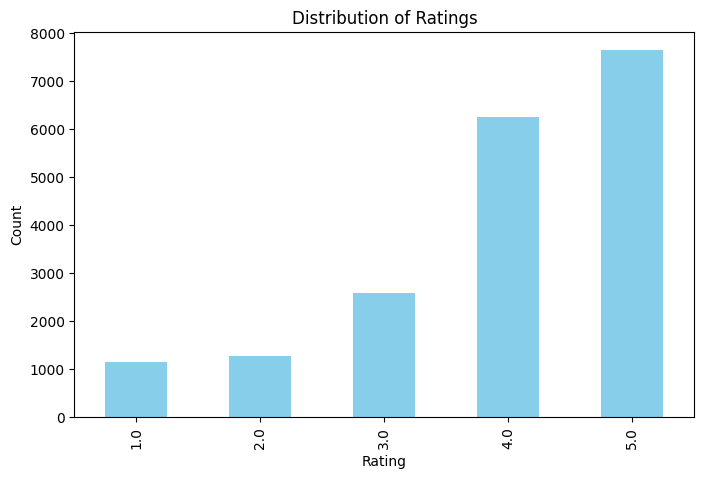

In [81]:
import matplotlib.pyplot as plt

# Plot distribution of ratings
train_df['ratings.overall'].value_counts().sort_index().plot(kind='bar', figsize=(8,5), color='skyblue')

plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of Ratings")
plt.show()

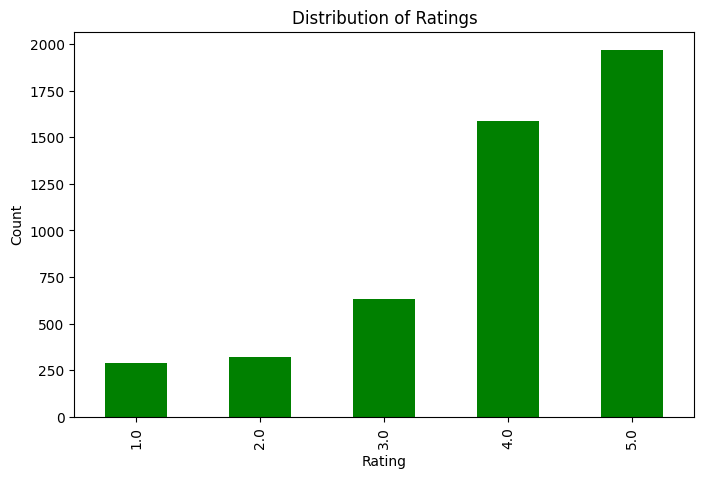

In [82]:
import matplotlib.pyplot as plt

# Plot distribution of ratings
test_df['ratings.overall'].value_counts().sort_index().plot(kind='bar', figsize=(8,5), color='green')

plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of Ratings")
plt.show()

In [83]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)  # Remove common words
tf_idf_train = vectorizer.fit_transform(train_df["text"])

# Convert to DataFrame
tfidf_df = pd.DataFrame(tf_idf_train.toarray(), columns=vectorizer.get_feature_names_out())

correlations = tfidf_df.corrwith(train_df["ratings.overall"])
correlations = correlations.sort_values(ascending=False)  # Sort by importance

# Find words with the weakest correlation (near zero)
non_predictive_words = correlations.sort_values(key=lambda x: np.abs(x))
print("Non-Predictive Words:\n", non_predictive_words.head(10))

# Display top positive and negative correlated words
print("Most Positive Words:\n", correlations.head(10))
print("\nMost Negative Words:\n", correlations.tail(10))

Non-Predictive Words:
 departure     -6.234440e-08
trek           1.468437e-06
entrances     -2.245296e-05
preferences    4.095579e-05
imagined       4.559375e-05
youve          4.587158e-05
morgans       -5.093558e-05
northern       5.502587e-05
japanese       6.591114e-05
watch         -7.536149e-05
dtype: float64
Most Positive Words:
 great          0.247711
staff          0.183024
friendly       0.163420
comfortable    0.155189
helpful        0.151183
wonderful      0.148285
perfect        0.146872
excellent      0.139383
highly         0.133028
definitely     0.125762
dtype: float64

Most Negative Words:
 room       -0.148204
called     -0.148382
carpet     -0.152117
terrible   -0.159664
horrible   -0.161720
said       -0.184708
rude       -0.185430
worst      -0.212914
dirty      -0.226350
told       -0.256448
dtype: float64


In [85]:
# Create a column with the title and text together
train_df["combined_text"] = train_df["title"] + " " + train_df["text"]
test_df["combined_text"] = test_df["title"] + " " + test_df["text"]

train_df = train_df.drop(columns=["title", "text"])
test_df = test_df.drop(columns=["title", "text"])
train_df = train_df.rename(columns={"ratings.overall": "rating", "combined_text": "text"})
test_df = test_df.rename(columns={"ratings.overall": "rating", "combined_text": "text"})

# Split all reviews into words and find unique ones
all_words_text = train_df.text.apply(nltk.word_tokenize)

unique_words = np.unique(all_words_text)

print("Total Unique Words:", len(unique_words))

KeyError: 'title'

In [86]:
train_df.head()

,rating,text
0,4.0,Great location and service Close to Union Squa...
1,2.0,I will never go back here again I had a bad vi...
2,1.0,Ripped off our VISA card after departure After...
3,4.0,A great location Steps to Grand Central a very...
4,3.0,Its all about the Location This Hotel is locat...


In [87]:
test_df.head()

,rating,text
0,5.0,I was SO surprised I WILL return My husband an...
1,5.0,A MotherDaughter vacation I could not leave a ...
2,4.0,Good Choice for Precruise I spent one night at...
3,5.0,Great Value for a King Queen and Princesses Gr...
4,4.0,Pleasant stay Great location in the heart of l...


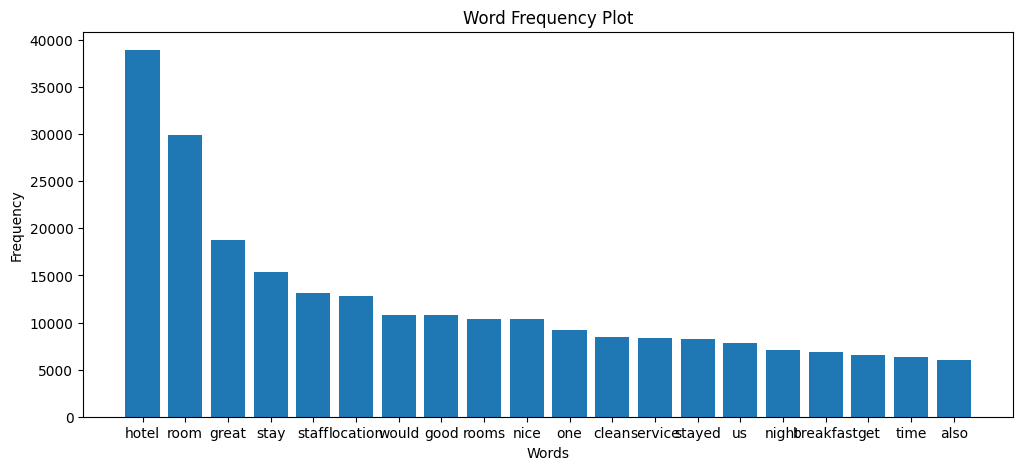

In [88]:
from collections import Counter
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

tokens = [
    word.lower() for sentence in unique_words.tolist()
    for s in sentence
    for word in word_tokenize(s)
    if word.isalnum() and word.lower() not in stop_words
]

word_freq = Counter(tokens)

plt.figure(figsize=(12, 5))
plt.bar(*zip(*word_freq.most_common(20)))
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Plot")
plt.show()


Distribution of 3-grams:
within walking distance: 777
front desk staff: 690
hotel great location: 672
staff friendly helpful: 575
would definitely stay: 546
great place stay: 399
would recommend hotel: 309
empire state building: 289
flat screen tv: 285
stayed one night: 263
would highly recommend: 258
highly recommend hotel: 254
new york city: 246
great location great: 244
called front desk: 212
great hotel great: 211
right across street: 204
hotel good location: 193
recommend hotel anyone: 190
would definitely recommend: 177
stay great location: 165
easy walking distance: 159
stayed 3 nights: 152
great location stayed: 150
hotel staff friendly: 140
king size bed: 137
stayed two nights: 132
walk times square: 129
right next door: 127
room clean comfortable: 125
stayed 4 nights: 122
home away home: 121
front desk clerk: 121
definitely stay great: 120
friendly helpful staff: 119
really enjoyed stay: 118
stayed 2 nights: 117
good value money: 117
made us feel: 115
nice hotel great: 115
lo

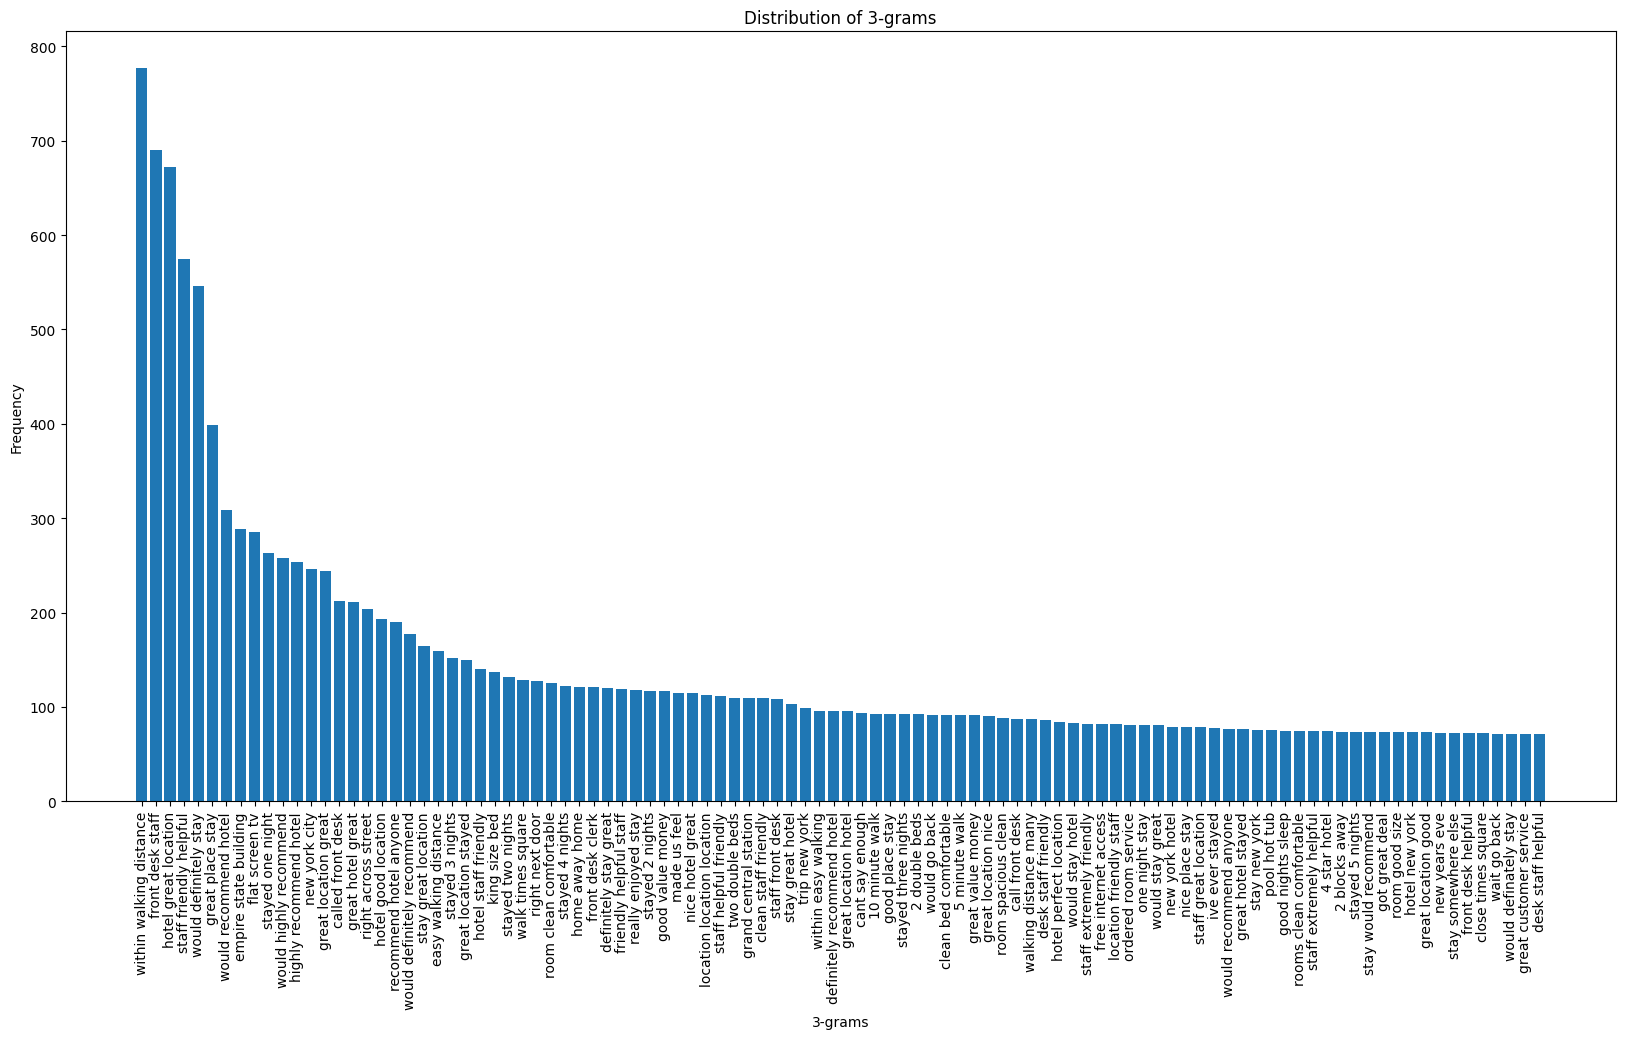

In [89]:
# Identifying common N-grams: N-grams are sequences of words.
from nltk import ngrams
from collections import Counter
import matplotlib.pyplot as plt

# Function to generate n-grams
def generate_ngrams(text, n):
    n_grams = ngrams(text, n)
    return [' '.join(gram) for gram in n_grams]

# Specify the value of n for n-grams
n_value = 3  # You can change this value to see different n-grams, e.g., 2 for bigrams, 3 for trigrams, etc.

# Generate n-grams
ngrams_list = generate_ngrams(tokens, n_value)

# Count the occurrences of each n-gram
ngrams_count = Counter(ngrams_list)
most_common_ngrams = ngrams_count.most_common(100)

# Display the distribution
print(f"Distribution of {n_value}-grams:")
for ngram, count in most_common_ngrams:
    print(f"{ngram}: {count}")

# Plot the distribution
labels, values = zip(*most_common_ngrams)
indexes = range(len(labels))

plt.figure(figsize=(20, 10))
plt.bar(indexes, values)
plt.xlabel(f'{n_value}-grams')
plt.ylabel('Frequency')
plt.xticks(indexes, labels, rotation='vertical')
plt.title(f'Distribution of {n_value}-grams')
plt.show()

### 3. Selection and training Machine Learning models

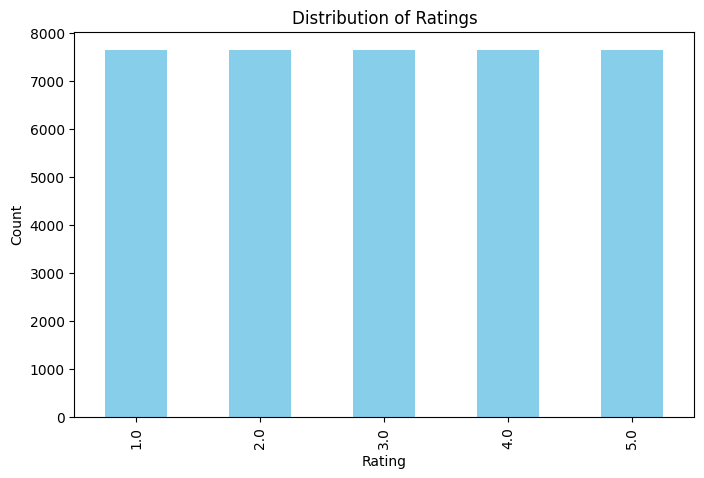

In [90]:
# Balance the training data by oversampling
def balance_data_oversample(df):
    max_count = df['rating'].value_counts().max()
    balanced_df = pd.DataFrame()

    for rating in df['rating'].unique():
        rating_df = df[df['rating'] == rating]
        balanced_df = pd.concat([balanced_df, rating_df.sample(max_count, replace=True)])

    return balanced_df
balanced_train_df = balance_data_oversample(train_df)

# Plot distribution of ratings
balanced_train_df['rating'].value_counts().sort_index().plot(kind='bar', figsize=(8,5), color='skyblue')

plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of Ratings")
plt.show()

In [91]:
# Change the text to lowercase
train_df.loc[:, 'text'] = train_df['text'].str.lower()
test_df.loc[:, 'text'] = test_df['text'].str.lower()
# Remove stop words
train_df.loc[:, 'text'] = train_df['text'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))
test_df.loc[:, 'text'] = test_df['text'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))
# Lemmatize the text
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
train_df.loc[:, 'text'] = train_df['text'].apply(lambda x: ' '.join(lemmatizer.lemmatize(word) for word in x.split()))
test_df.loc[:, 'text'] = test_df['text'].apply(lambda x: ' '.join(lemmatizer.lemmatize(word) for word in x.split()))

[nltk_data] Downloading package wordnet to /home/dev/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [92]:
from sklearn.model_selection import train_test_split

X_res = balanced_train_df["text"]
y_res = balanced_train_df["rating"]

X_train, X_val, y_train, y_val = train_test_split(X_res, y_res, test_size=0.2, shuffle=True)


In [93]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X_train_vectors = vectorizer.fit_transform(X_train)
X_val_vectors = vectorizer.transform(X_val)

In [94]:
from sklearn.model_selection import cross_val_score


#### Multinomial Naive Bayes

In [95]:
from sklearn.naive_bayes import MultinomialNB

# https://www.geeksforgeeks.org/multinomial-naive-bayes/

classifier = MultinomialNB()

In [96]:
nb_accuracies = cross_val_score(classifier, X_train_vectors, y_train, cv=5)
classifier.fit(X_train_vectors, y_train)
print("Naive Bayes Train Score:", np.mean(nb_accuracies))

Naive Bayes Train Score: 0.7635656622032853


In [97]:
naive_bayes_score = classifier.score(X_val_vectors, y_val)
print("Naive Bayes Test Score:", naive_bayes_score)

Naive Bayes Test Score: 0.7743200836820083


In [98]:
import tensorflow as tf

# Limit GPU memory usage
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.set_logical_device_configuration(
                gpu,
                [tf.config.LogicalDeviceConfiguration(memory_limit=(6 * 1024))])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [99]:
from tensorflow.keras.utils import to_categorical

train_Y = balanced_train_df["rating"]
train_Y_cat = to_categorical(balanced_train_df["rating"]-1, num_classes=5)

test_Y = test_df["rating"]
test_Y_cat = to_categorical(test_df["rating"]-1, num_classes=5)

In [100]:
import requests
import zipfile

#https://towardsdatascience.com/1-to-5-star-ratings-classification-or-regression-b0462708a4df/
#https://www.kaggle.com/code/sebastianpoliak/classification-or-regression

glove_dir = '../glove'
if not os.path.exists(glove_dir):
    os.makedirs(glove_dir)

glove_url = "http://nlp.stanford.edu/data/glove.6B.zip"
glove_zip_path = os.path.join(glove_dir, "glove.6B.zip")

# Download the GloVe file
if not os.path.exists(glove_zip_path):
    print("Downloading GloVe embeddings...")
    response = requests.get(glove_url, stream=True)
    with open(glove_zip_path, "wb") as f:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
    print("Download complete.")

# Extract the GloVe file
if not os.path.exists(os.path.join(glove_dir, "glove.6B.100d.txt")):
    print("Extracting GloVe embeddings...")
    with zipfile.ZipFile(glove_zip_path, "r") as zip_ref:
        zip_ref.extractall(glove_dir)
    print("Extraction complete.")

embedding_index = {}
f = open(os.path.join(glove_dir,'glove.6B.100d.txt'),encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype='float32')
    embedding_index[word] = coefs
f.close()
print('Found %s word vectors ' % len(embedding_index))

Found 400000 word vectors 


In [101]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer=Tokenizer(oov_token="'oov'")
tokenizer.fit_on_texts(balanced_train_df['text'])

max_words = len(tokenizer.word_index) + 1
embedding_dim = 100
embedding_matrix = np.zeros((max_words,embedding_dim))

for word, idx in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx]=embedding_vector

In [102]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
maxlen = 200
train_X = pad_sequences(tokenizer.texts_to_sequences(balanced_train_df['text']), maxlen=maxlen)
test_X = pad_sequences(tokenizer.texts_to_sequences(test_df['text']), maxlen=maxlen)

In [103]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

#https://towardsdatascience.com/1-to-5-star-ratings-classification-or-regression-b0462708a4df/
#https://www.kaggle.com/code/sebastianpoliak/classification-or-regression

model=Sequential()
model.add(Embedding(max_words, embedding_dim, weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(8)))
model.add(Dense(4, activation="relu"))
model.add(Dense(1, activation="linear"))

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error')
model.build(train_X.shape)
print(model.summary())

# Train the model
history = model.fit(
    train_X,
    train_Y,
    epochs=25,
    batch_size=256,
    validation_split=0.2,
)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (38240, 200, 100)      │     4,100,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (38240, 16)            │         6,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (38240, 4)             │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (38240, 1)             │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,107,049 (15.67 MB)

 Trainable params: 7,049 (27.54 KB)

 Non-trainable params: 4,100,000 (15.64 MB)

None
Epoch 1/25
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 5.0155 - val_loss: 16.7792
Epoch 2/25
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 3.3708 - val_loss: 13.6313
Epoch 3/25
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 2.3929 - val_loss: 9.6065
Epoch 4/25
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.5206 - val_loss: 7.1608
Epoch 5/25
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.3015 - val_loss: 6.5280
Epoch 6/25
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.2536 - val_loss: 6.2922
Epoch 7/25
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.2475 - val_loss: 6.1670
Epoch 8/25
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.2310 - val_loss: 6.1265
Epoch 9/25
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.2059 - val_loss: 5.9757
Epoch 10/25
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.1847 - val_loss: 5.8188
Epoch 11/25
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.1451 - val_loss: 5.4754
Epoch 12/25
120/120 ━━━━━━━━━━━━━━

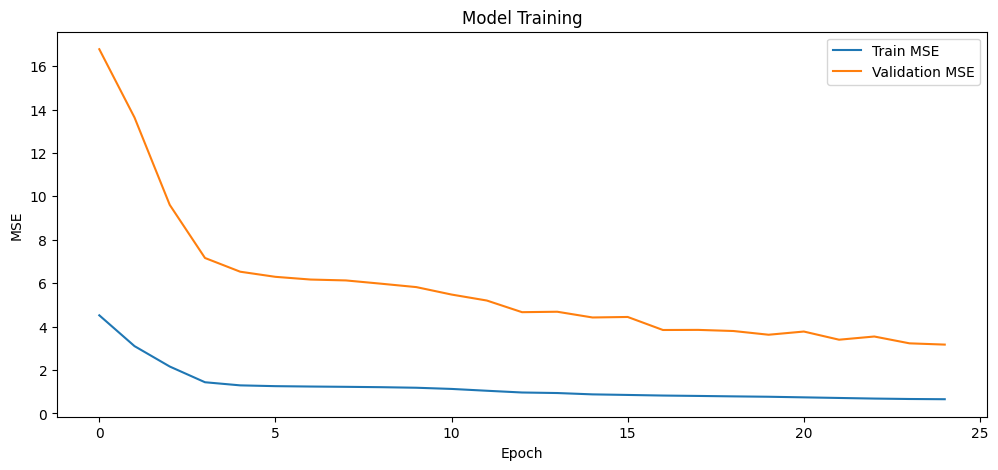

In [104]:
from matplotlib import pyplot as plt

# Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train MSE')
plt.plot(history.history['val_loss'], label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Model Training')
plt.legend()
plt.show()

In [105]:
# Predict the ratings for the test set and check the rating compared to the y_test_cat
predictions = model.predict(test_X)
# Compare the predictions with the actual ratings
predictions = np.round(predictions).astype(int)

# Calculate the mean squared error
mse = np.mean((predictions.flatten() - test_Y.to_numpy().flatten())**2)
print(f"Mean Squared Error: {mse:.2f}")

correct_predictions = np.sum(predictions.flatten() == test_Y.to_numpy().flatten())
total_predictions = len(predictions)
accuracy = correct_predictions / total_predictions
print(f"Model Accuracy: {accuracy:.2f}")


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Mean Squared Error: 2.19
Model Accuracy: 0.17


In [107]:
# Show the predictions which were incorrect by more than 1
incorrect_predictions = np.abs(predictions.flatten() - test_Y.to_numpy().flatten()) > 1
incorrect_reviews = test_df[incorrect_predictions]
print("Incorrect Predictions:")
for i, row in incorrect_reviews.iterrows():
    print(f"Text: {row['text']}")
    print(f"Predicted Rating: {predictions[i][0]}")
    print(f"Actual Rating: {row['rating']}")
    print("-" * 50)

# Print the number of incorrect predictions compared to the total number of predictions
num_incorrect = len(incorrect_reviews)
num_total = len(test_df)
print(f"Total Predictions: {num_total}")
print(f"Number of Correct Predictions: {num_total - num_incorrect}")
print(f"Number of Incorrect Predictions: {num_incorrect}")
# Print the accuracy based on the number of correct predictions
accuracy = (num_total - num_incorrect) / num_total
print(f"Accuracy: {accuracy:.2f}")

Incorrect Predictions:
Text: surprised return husband celebrated 25th wedding anniversary normally stay high class hotel night wanted try something new without spending fortune st regis ritz etc norm wanted tribeca area pulled hotel unassuming front bell guy nice took care bag right away checking least 3 people come u say happy anniversary starwood platinum set hopefully get upgrade gave 12000 point minimum told u could suite little disappointed would fine giving u great view manager came changed everything gave u nicest suite ever gave u top floor brought champagne chocolate strawberry quickly room best ever room simple beautiful view amazing bed soooo comfortable slept like baby cant say enough bathroom sooo nice would give bathroom 5 star im kidding sheraton impressive dont know havent hotel know nice everyone extremely comfortable made u go back soon go city lot sure go back thank much sheraton wowed u
Predicted Rating: 3
Actual Rating: 5.0
-----------------------------------------

### 4. Experiment with VADER sentiment lexicon

In [108]:
# Load libraries
import numpy as np
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import tree

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def include_sentiment_analysis(df):
    df2 = df.copy()
    # Create text data from text and title
    text_data = df2["text"].to_numpy()

    # Create target vector
    y = train_Y.apply(lambda x: "positive" if x > 3 else ("negative" if x < 3 else "neutral")).tolist()

    # Analyse with VADER
    analyser = SentimentIntensityAnalyzer()
    correct_predictions = 0

    for text in text_data:
        score = analyser.polarity_scores(text)
        sentiment = "neutral"
        # If the compound score is greater than 0.05, it is positive
        # If the compound score is less than -0.05, it is negative
        # If the compound score is between -0.05 and 0.05, it is neutral
        if score['compound'] > 0.05:
            sentiment = "positive"
        elif score['compound'] < -0.05:
            sentiment = "negative"
        
        # Compare the predicted sentiment with the actual sentiment
        index = text_data.tolist().index(text)
        if sentiment == y[index]:
            correct_predictions += 1
            # Add the score to the balanced_train_df in a new column
            if index < len(df2):  # Ensure we are updating the correct row
                df2.loc[df2["text"] == text, "VADER_Sentiment"] = sentiment
        else:
            # Add the score based on the y value for sentiment
            if y[index] == "positive":
                if index < len(df2):
                    df2.loc[df2["text"] == text, "VADER_Sentiment"] = "positive"
            elif y[index] == "negative":
                if index < len(df2):
                    df2.loc[df2["text"] == text, "VADER_Sentiment"] = "negative"
            else:
                if index < len(df2):
                    df2.loc[df2["text"] == text, "VADER_Sentiment"] = "neutral"

    # Print the number of correct predictions
    print(f"Correct Predictions: {correct_predictions}")
    # Print the accuracy
    accuracy = correct_predictions / len(text_data)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    return df2


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/dev/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [109]:
balanced_train_df2 = include_sentiment_analysis(balanced_train_df)
train_X = pad_sequences(tokenizer.texts_to_sequences(balanced_train_df2['text']), maxlen=maxlen)
# Create a training set with the vader sentiment represented as -1 if neutral, 0 if negative and 1 if positive
train_X = np.concatenate((train_X, np.array(balanced_train_df2["VADER_Sentiment"].apply(lambda x: 1 if x == "positive" else (-1 if x == "negative" else 0)).tolist()).reshape(-1, 1)), axis=1)

Correct Predictions: 22704
Accuracy: 59.37%


In [110]:
# Train the model
history = model.fit(
    train_X,
    train_Y,
    epochs=25,
    batch_size=256,
    validation_split=0.2,
)


Epoch 1/25
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.6141 - val_loss: 3.0669
Epoch 2/25
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.4459 - val_loss: 2.8252
Epoch 3/25
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.3311 - val_loss: 2.5840
Epoch 4/25
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.2757 - val_loss: 2.4042
Epoch 5/25
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.2495 - val_loss: 2.3129
Epoch 6/25
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.2387 - val_loss: 2.1903
Epoch 7/25
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.2354 - val_loss: 2.2190
Epoch 8/25
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.2323 - val_loss: 2.1416
Epoch 9/25
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.2297 - val_loss: 2.1727
Epoch 10/25
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.2276 - val_loss: 2.0916
Epoch 11/25
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.2259 - val_loss: 2.1483
Epoch 12/25
120/120 ━━━━━━━━━━━━━━━━━━━━ 

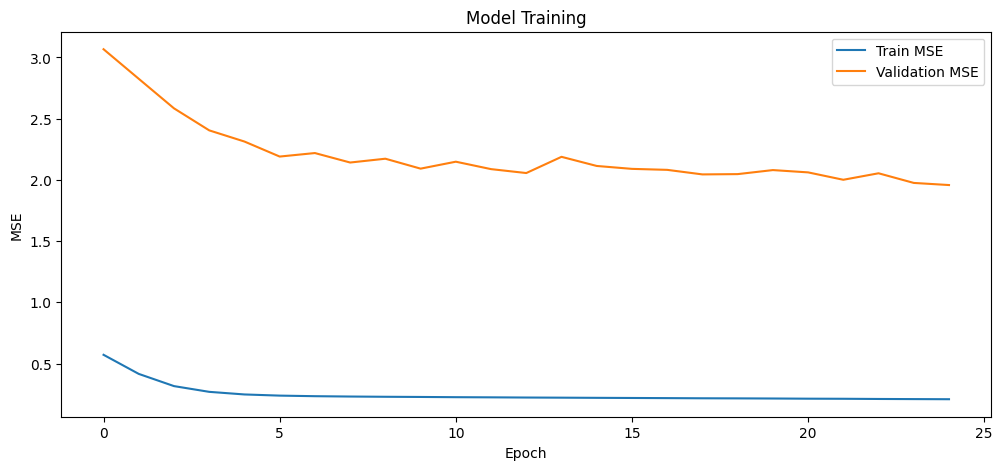

In [111]:
from matplotlib import pyplot as plt

# Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train MSE')
plt.plot(history.history['val_loss'], label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Model Training')
plt.legend()
plt.show()

In [112]:
test_df2 = include_sentiment_analysis(test_df)
test_X = pad_sequences(tokenizer.texts_to_sequences(test_df2['text']), maxlen=maxlen)
# Create a training set with the vader sentiment represented as -1 if neutral, 0 if negative and 1 if positive
test_X = np.concatenate((test_X, np.array(test_df2["VADER_Sentiment"].apply(lambda x: 1 if x == "positive" else (-1 if x == "negative" else 0)).tolist()).reshape(-1, 1)), axis=1)

# Predict the ratings for the test set and check the rating compared to the y_test_cat
predictions = model.predict(test_X)
# Compare the predictions with the actual ratings
predictions = np.round(predictions).astype(int)

# Calculate the mean squared error
mse = np.mean((predictions.flatten() - test_Y.to_numpy().flatten())**2)
print(f"Mean Squared Error: {mse:.2f}")

correct_predictions = np.sum(predictions.flatten() == test_Y.to_numpy().flatten())
total_predictions = len(predictions)
accuracy = correct_predictions / total_predictions
print(f"Model Accuracy: {accuracy:.2f}")


Correct Predictions: 4510
Accuracy: 93.98%
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Mean Squared Error: 0.98
Model Accuracy: 0.34


In [113]:
# Show the predictions which were incorrect by more than 2
incorrect_predictions = np.abs(predictions.flatten() - test_Y.to_numpy().flatten()) > 1
incorrect_reviews = test_df[incorrect_predictions]
print("Incorrect Predictions:")
for i, row in incorrect_reviews.iterrows():
    print(f"Text: {row['text']}")
    print(f"Predicted Rating: {predictions[i][0]}")
    print(f"Actual Rating: {row['rating']}")
    print("-" * 50)

# Print the number of incorrect predictions compared to the total number of predictions
num_incorrect = len(incorrect_reviews)
num_total = len(test_df)
print(f"Total Predictions: {num_total}")
print(f"Number of Correct Predictions: {num_total - num_incorrect}")
print(f"Number of Incorrect Predictions: {num_incorrect}")
# Print the accuracy based on the number of correct predictions
accuracy = (num_total - num_incorrect) / num_total
print(f"Accuracy: {accuracy:.2f}")

Incorrect Predictions:
Text: cant wait return london nyc absolutely overthetop experience beginning end least expensive spot town defy find hotel caliber offer suite size lower price wont since hotel freshly renovated every inch property spotless fresh london suite 17th floor silent window closed suite parlor separated bedroom small entryway welllit bathroom enormous huge mirror bathroom wall separated fabulous light panel made makeup application breeze addition shower area 9 x 4 rain shower type fixture one end shower massage fixture also euro handheld fixture base covered regarding showering option bed offered super deluxe pillowtop comfort pillow fab linen high threadcount sateen ambiance minimalistelegant suite throughout hotel didnt try restaurantbar loved every moment look forward returning hopefully discounted rate continue forever
Predicted Rating: 3
Actual Rating: 5.0
--------------------------------------------------
Text: nice place good deal liked room pillow bad reviewer i

### 5. Final testing on test set and discussion of results

### 6. Propose a method to predict aspects 

***(COMP SCI 7417 and COMP SCI 7717 only)***

### 7. Reflection on the ***Product*** development.

### 9. References

https://pandas.pydata.org/pandas-docs/version/1.2.0/reference/api/pandas.json_normalize.html

https://www.analyticsvidhya.com/blog/2022/07/step-by-step-exploratory-data-analysis-eda-using-python/

https://pawarbi.github.io/blog/pandas/numpy/data-cleaning/2021/03/05/removing-non-alphanumeric-symbols-characters-from-column-numpy-pandas-dataframe.html


### Appendix